# New York Temperature Data

In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

In [97]:
temp = pd.read_csv('NY_temperature.csv', index_col=0, header=0)
# Convert index to datetime object
temp.index = pd.to_datetime(temp.index, format='%Y')
temp.index.freq = 'AS-JAN'
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147 entries, 1870-01-01 to 2016-01-01
Freq: AS-JAN
Data columns (total 1 columns):
TAVG    147 non-null float64
dtypes: float64(1)
memory usage: 2.3 KB


,TAVG
DATE,
1870-01-01,53.8
1871-01-01,51.3
1872-01-01,51.3
1873-01-01,50.9
1874-01-01,51.3


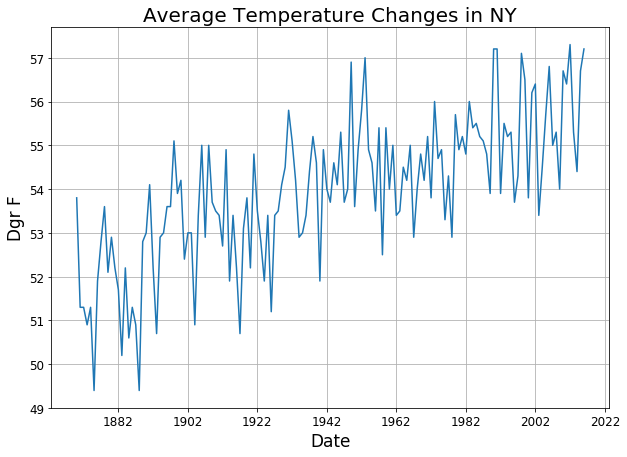

In [89]:
plt.plot(temp)
plt.title('Average Temperature Changes in NY', fontsize = '20')
plt.ylabel('Dgr F', fontsize = '17')
plt.xlabel('Date', fontsize='17', horizontalalignment='center')
plt.grid()
plt.show()

There is an upwards drift in average temperatures. The series appears as an AR-process, as present values look to be an averaging of past values. We must stationarize the series to perform further analysis.

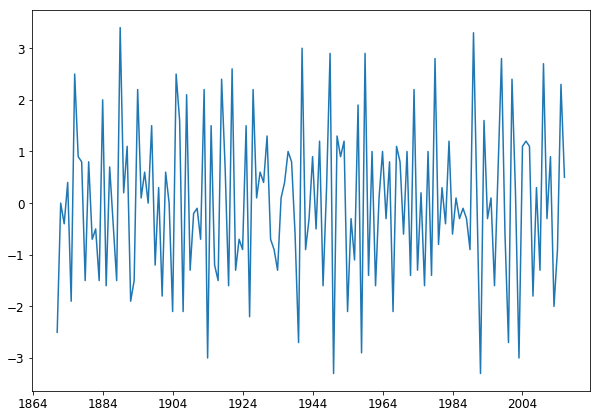

In [90]:
temp_diff = temp.diff().dropna() # first val becomes NaN
plt.plot(temp_diff)
plt.show()

The plot of series suggests that taking first differences obtains stationarity. We will use the augmented Dickey-Fuller unit root test to confirm.

In [76]:
adf = adfuller(temp_diff['TAVG'])
print('The p-value of the test on sales is: ' + str(adf[1]))

The p-value of the test on sales is: 9.82453383770732e-14


Therefore we reject the null hyppothesis that the series has a unit root.

To select an appropriate lag order we look at the sample autocorrelation plot of the stationary series.

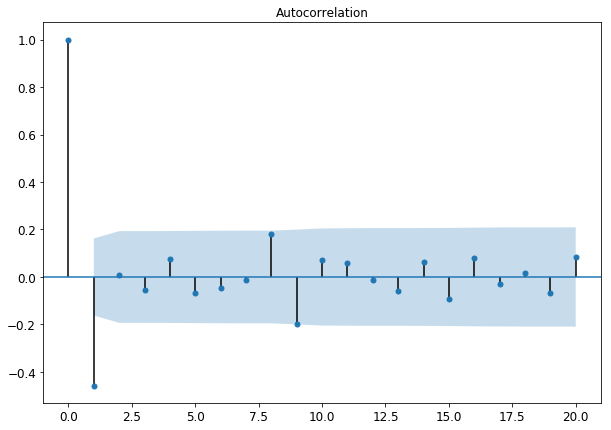

In [83]:
plot_acf(temp_diff, lags=20)
plt.show()

The SACF plot  of the stationary series suggests using an order of 1 for model determination.

In [98]:
ar_mod = ARIMA(temp, order=(1,1,0))
res1 = ar_mod.fit()
print(res1.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TAVG   No. Observations:                  146
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -252.267
Method:                       css-mle   S.D. of innovations              1.361
Date:                Fri, 28 Jun 2019   AIC                            510.535
Time:                        11:05:16   BIC                            519.486
Sample:                    01-01-1871   HQIC                           514.172
                         - 01-01-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0277      0.077      0.360      0.720      -0.123       0.179
ar.L1.D.TAVG    -0.4629      0.074     -6.278      0.000      -0.607      -0.318
                                    Roots   

In [100]:
arma_mod = ARIMA(temp, order=(1,1,1))
res2 = arma_mod.fit()
print(res2.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TAVG   No. Observations:                  146
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -230.536
Method:                       css-mle   S.D. of innovations              1.155
Date:                Fri, 28 Jun 2019   AIC                            469.073
Time:                        11:07:26   BIC                            481.007
Sample:                    01-01-1871   HQIC                           473.922
                         - 01-01-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0280      0.003     10.918      0.000       0.023       0.033
ar.L1.D.TAVG     0.1272      0.083      1.527      0.129      -0.036       0.291
ma.L1.D.TAVG    -1.0000      0.023    -43.96

Comparing the above models:

In [92]:
print("BIC for model 1: " + str(res1.bic))
print("BIC for model 2: " + str(res2.bic))

BIC for model 1: 519.4855096965161
BIC for model 2: 481.0073404796659


We choose the ARIMA(1,1,1) model.

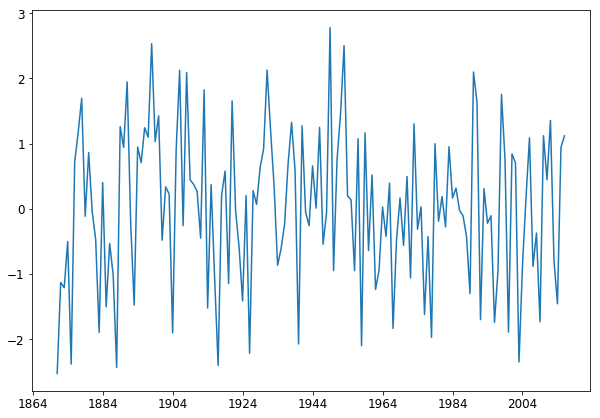

In [103]:
resid = pd.DataFrame(res2.resid)
plt.plot(resid)

(array([0.0252654]), array([0.87370752]))


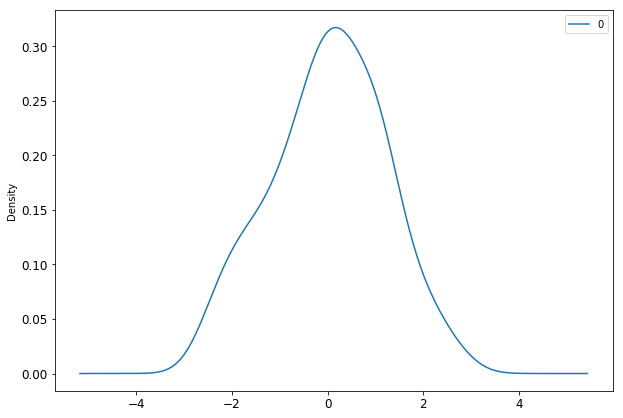

In [113]:
resid.plot(kind='kde')
lb = acorr_ljungbox(resid, lags=1)
print(lb)

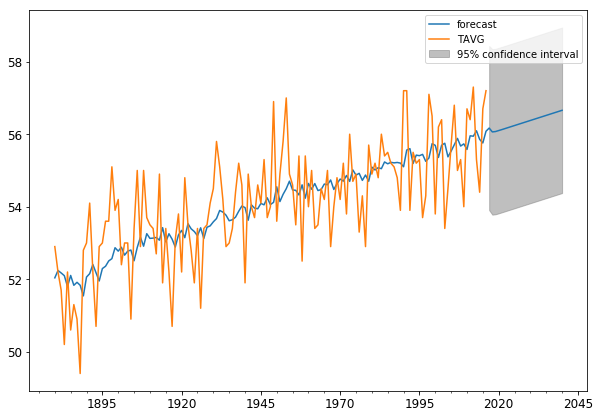

In [102]:
res2.plot_predict(start='1880-01-01', end='2040-01-01')
plt.show()

The model predicts a temperature rise in about 0.5 degrees over the next 20 years due to the series trend.